In [1]:
# Import libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

from PIL import Image
from google.colab import files
from matplotlib.image import imread

In [2]:
uploaded = files.upload()

for fn in uploaded.keys():
  print("User uploaded file {name} with length {length} bytes".format(
      name=fn, length=len(uploaded[fn])))
  
# Move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file kaggle.json with length 63 bytes


In [3]:
# Import dataset
!kaggle competitions download -c dogs-vs-cats

!unzip -q "test1.zip"
!unzip -q "train.zip"

 98% 265M/271M [00:04<00:00, 103MB/s]
100% 271M/271M [00:04<00:00, 67.3MB/s]
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 84.9MB/s]
 99% 539M/543M [00:03<00:00, 161MB/s]
100% 543M/543M [00:03<00:00, 167MB/s]


In [4]:
# Define location of datasets
train_folder = '/content/train/'
test_folder = '/content/test1/'

In [5]:
# plot first few test images
def plot_images(animal_type: str, folder: str):
  for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.axis("off")

    filename = folder + animal_type + '.' + str(i) + '.jpg'
    image = imread(filename)

    plt.imshow(image)
  plt.show()

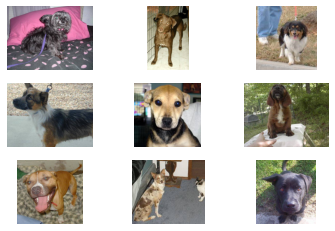

In [6]:
plot_images("dog", train_folder)

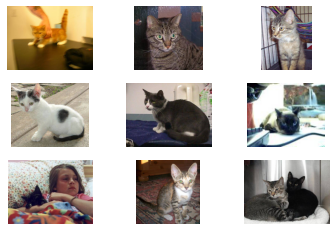

In [7]:
plot_images("cat", train_folder)

In [8]:
# Create dataset
filenames=os.listdir(train_folder)

categories=[]
for f_name in filenames:
    category=f_name.split('.')[0]
    categories.append(category)

filenames = [train_folder + filename for filename in filenames]
df = pd.DataFrame({
    "filename": filenames,
    "category": categories
})

df.head()

,filename,category
0,/content/train/cat.6175.jpg,cat
1,/content/train/cat.5854.jpg,cat
2,/content/train/cat.12053.jpg,cat
3,/content/train/dog.6104.jpg,dog
4,/content/train/cat.2538.jpg,cat


In [9]:
# Image variables
img_height = 128
img_width = 128
img_size = (img_height, img_width)
batch_size = 32

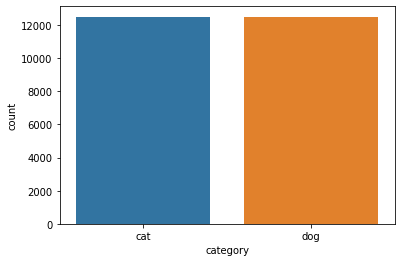

In [10]:
# Category distribution
sns.countplot(x="category", data=df)

In [11]:
# Split into train and test
train_df, test_df = train_test_split(df, test_size=0.20, random_state=42)

In [12]:
# Reset index
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [13]:
# Data augmentation
train_datagen = ImageDataGenerator(
  rescale=1./255, # normalize images
  rotation_range=30, # randomly rotate images in the range 5 degrees
  width_shift_range=0.1, # randomly shift images horizontally 10%
  height_shift_range=0.1, # randomly shift images vertically 10%
  zoom_range=0.2, # Randomly zoom image 20%
  horizontal_flip=True, # randomly flip images horizontally
)

train_generator = train_datagen.flow_from_dataframe(
  train_df,
  train_folder,
  x_col='filename',
  y_col='category',
  target_size=img_size,
  class_mode='categorical',
  batch_size=batch_size
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    test_df, 
    test_folder, 
    x_col='filename',
    y_col='category',
    target_size=img_size,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [14]:
model = Sequential()

model.add(Conv2D(32,(3,3),activation='relu',input_shape=(img_width, img_height, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(1024,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(2,activation='sigmoid'))

earlystop = EarlyStopping(patience=5)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.5, min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]

opt = Adam(learning_rate=0.001)

model.compile(
  loss='binary_crossentropy',
  optimizer=opt,
  metrics=['accuracy']
)

history = model.fit(
    train_generator, 
    epochs=25,
    validation_data=test_generator,
    callbacks=callbacks,
    batch_size=batch_size
)

Epoch 1/25
625/625 [==============================] - 183s 218ms/step - loss: 0.8510 - accuracy: 0.6207 - val_loss: 0.6264 - val_accuracy: 0.6588
Epoch 2/25
625/625 [==============================] - 133s 213ms/step - loss: 0.5731 - accuracy: 0.7133 - val_loss: 0.4684 - val_accuracy: 0.7710
Epoch 3/25
625/625 [==============================] - 136s 217ms/step - loss: 0.5143 - accuracy: 0.7498 - val_loss: 0.6792 - val_accuracy: 0.7160
Epoch 4/25
625/625 [==============================] - 137s 219ms/step - loss: 0.4583 - accuracy: 0.7830 - val_loss: 0.5520 - val_accuracy: 0.7416

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/25
625/625 [==============================] - 135s 216ms/step - loss: 0.4207 - accuracy: 0.8098 - val_loss: 0.4111 - val_accuracy: 0.8192
Epoch 6/25
625/625 [==============================] - 134s 215ms/step - loss: 0.3758 - accuracy: 0.8290 - val_loss: 0.3584 - val_accuracy: 0.8402
Epoch 7/25
625/625 [=======================

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

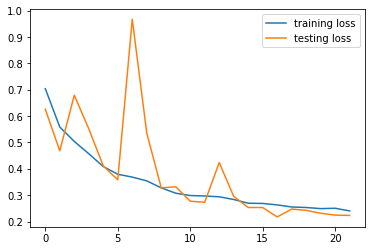

In [16]:
plt.plot(history.history["loss"], label="training loss")
plt.plot(history.history["val_loss"], label="testing loss")
plt.legend();

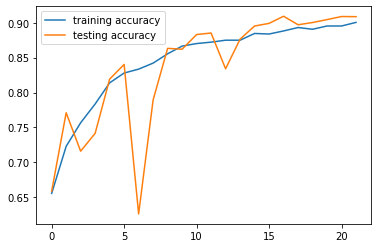

In [17]:
plt.plot(history.history["accuracy"], label="training accuracy")
plt.plot(history.history["val_accuracy"], label="testing accuracy")
plt.legend();

In [18]:
model.save("model")

INFO:tensorflow:Assets written to: model/assets


In [19]:
!zip -r model.zip model

  adding: model/ (stored 0%)
  adding: model/assets/ (stored 0%)
  adding: model/variables/ (stored 0%)
  adding: model/variables/variables.data-00000-of-00001 (deflated 6%)
  adding: model/variables/variables.index (deflated 71%)
  adding: model/keras_metadata.pb (deflated 93%)
  adding: model/saved_model.pb (deflated 90%)
